In [195]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
engine = create_engine("sqlite:///data/mta_turnstile.db")

In [197]:
all_tables = engine.table_names()
all_tables
some_tables = all_tables[5:26]
len(some_tables)

21

In [198]:
dfs = []
for table in some_tables:
    dfs.append(pd.read_sql(table,engine))
    mtadf = pd.concat(dfs)
mtadf.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/02/2019,03:00:00,REGULAR,6930882,2350417
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/02/2019,07:00:00,RECOVR AUD,6930901,2350428
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/02/2019,11:00:00,RECOVR AUD,6930964,2350499
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/02/2019,15:00:00,REGULAR,6931126,2350567
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/02/2019,19:00:00,REGULAR,6931404,2350639


In [199]:
print('DTYPES:\n',mtadf.dtypes,'\n')
print(mtadf.columns)
print(mtadf.shape)

DTYPES:
 C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                  int64
EXITS                                                                    int64
dtype: object 

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',


In [200]:
# fix the insane amount of space after 'EXITS'
mtadf.rename(str.strip, axis='columns',inplace=True)
mtadf.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [201]:
# change DATE and TIME to datetime objects
mtadf['OBSERVED_AT'] = pd.to_datetime(mtadf['DATE']+ ' ' + mtadf['TIME'], 
                                      format='%m/%d/%Y %H:%M:%S')

In [202]:
# 21 days of data AKA 3 weeks
# mtadf.DATE.value_counts().sort_index()

In [203]:
# SAVE FOR LATER
# create column for day of week
# mtadf['WEEKDAY']=mtadf['OBSERVED_AT'].dt.dayofweek
# change WEEKDAY from int64 to string Monday-Sunday
'''daymap = {0:'Monday',
          1: 'Tuesday',
          2: 'Wednesday',
          3: 'Thursday',
          4: 'Friday',
          5: 'Saturday',
          6: 'Sunday'}
mtadf['WEEKDAY']=mtadf['WEEKDAY'].map(daymap)
'''

"daymap = {0:'Monday',\n          1: 'Tuesday',\n          2: 'Wednesday',\n          3: 'Thursday',\n          4: 'Friday',\n          5: 'Saturday',\n          6: 'Sunday'}\nmtadf['WEEKDAY']=mtadf['WEEKDAY'].map(daymap)\n"

In [204]:
# create some other columns based on the datetime object
mtadf['MONTH'] = mtadf.OBSERVED_AT.dt.month
mtadf['DAY'] = mtadf.OBSERVED_AT.dt.day

# don't end up using
# mtadf['HOUR'] = mtadf.OBSERVED_AT.dt.hour
# mtadf['MIN'] = mtadf.OBSERVED_AT.dt.minute

In [205]:
# create identifyer for each turnstile then drop original columns
mtadf['TURNSTILE'] = mtadf['UNIT'] + '-' + mtadf['C/A'] + '-' + mtadf['SCP']

# didn't end up needing this
# mtadf['TURNSTILE_ID'] = mtadf['UNIT'] + '-' + mtadf['C/A'] + '-' + mtadf['SCP']\
                       # + '-' + mtadf['DATE'] + '-' + mtadf['TIME']

In [206]:
mtadf.drop(['C/A','UNIT','SCP'],axis=1,inplace=True)

In [207]:
mtadf.columns

Index(['STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS', 'OBSERVED_AT', 'MONTH', 'DAY', 'TURNSTILE'],
      dtype='object')

In [208]:
# rearrange order of columns
col_names = ['STATION','TURNSTILE','OBSERVED_AT',
             'DATE','MONTH','DAY','WEEKDAY','TIME',
             'ENTRIES','EXITS',
             'LINENAME','DIVISION','DESC']
mtadf = mtadf.reindex(columns=col_names)
mtadf.head(1)

,STATION,TURNSTILE,OBSERVED_AT,DATE,MONTH,DAY,WEEKDAY,TIME,ENTRIES,EXITS,LINENAME,DIVISION,DESC
0,59 ST,R051-A002-02-00-00,2019-02-02 03:00:00,02/02/2019,2,2,NaN,03:00:00,6930882,2350417,NQR456W,BMT,REGULAR


# NEW DATAFRAME: mtadfs
### SORTED BY STATION, MONTH, DAY

In [209]:
# sort the dataframe by station, then month/day/hour/min
mtadfs = mtadf.sort_values(['STATION','MONTH','DAY'])

In [210]:
mtadfs.OBSERVED_AT.dt.hour.value_counts()
#some observations are at HOUR 0 aka midnight

8     380082
16    362955
12    362258
20    362175
4     361427
0     360517
9     237211
17    230809
13    230259
5     229915
21    229644
1     227343
7      94504
11     92754
19     90308
15     89743
23     89302
3      88646
10     33217
18     30034
14     29306
6      29014
22     28435
2      27753
Name: OBSERVED_AT, dtype: int64

In [211]:
# create an hour offset
one_hour = pd.offsets.Hour()

In [212]:
# how many rows occur from midnight to midnight:59?
print('midnight hour:', mtadfs[mtadfs.OBSERVED_AT.dt.hour == 0].shape[0])
print('all rows:', mtadfs.shape[0])

midnight hour: 360517
all rows: 4297611


In [213]:
# if the observation was from midnight to midight:59
# subtract 1 hour so the log is included for the previous day
mtadfs['OBSERVED_AT'] = mtadfs['OBSERVED_AT'].apply(lambda x: x-one_hour if x.hour == 0 else x)

In [214]:
# update hour
# check if we have any instances of midnight to midnight:59
mtadfs['HOUR'] = mtadfs['OBSERVED_AT'].dt.hour
print(mtadfs[mtadfs['HOUR'] == 0])

Empty DataFrame
Columns: [STATION, TURNSTILE, OBSERVED_AT, DATE, MONTH, DAY, WEEKDAY, TIME, ENTRIES, EXITS, LINENAME, DIVISION, DESC, HOUR]
Index: []


# NEW DATAFRAME: mtadf_ts_daily
### CUMULATIVE DAILY VALUES PER TURNSTILE 
### (INCL LINENAME)

In [215]:
# get daily cumulative # per turnstile per day
# group by turnstile -- max value of that turnstile is the max value for that day
mtadf_ts_daily = mtadfs.groupby(['TURNSTILE','STATION','DATE','LINENAME'],as_index=False)\
                        [['ENTRIES','EXITS']].max()
mtadf_ts_daily

,TURNSTILE,STATION,DATE,LINENAME,ENTRIES,EXITS
0,R001-A058-01-00-00,WHITEHALL S-FRY,02/02/2019,R1W,1525378,3535298
1,R001-A058-01-00-00,WHITEHALL S-FRY,02/03/2019,R1W,1525517,3535841
2,R001-A058-01-00-00,WHITEHALL S-FRY,02/04/2019,R1W,1526696,3538392
3,R001-A058-01-00-00,WHITEHALL S-FRY,02/05/2019,R1W,1527829,3541027
4,R001-A058-01-00-00,WHITEHALL S-FRY,02/06/2019,R1W,1529096,3543759
...,...,...,...,...,...,...
711207,R572-N702A-01-03-04,96 ST-2 AVE,07/01/2019,Q,1136743,375829
711208,R572-N702A-01-03-04,96 ST-2 AVE,07/02/2019,Q,1138209,376331
711209,R572-N702A-01-03-04,96 ST-2 AVE,07/03/2019,Q,1139639,376727
711210,R572-N702A-01-03-04,96 ST-2 AVE,07/04/2019,Q,1140333,376981


In [216]:
mtadf_ts_daily[['PREV_DATE','PREV_ENTRIES','PREV_EXITS']]=mtadf_ts_daily\
                            .groupby(['TURNSTILE','STATION'])[['DATE', 'ENTRIES','EXITS']]\
                            .apply(lambda grp: grp.shift(1))
mtadf_ts_daily            

,TURNSTILE,STATION,DATE,LINENAME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,R001-A058-01-00-00,WHITEHALL S-FRY,02/02/2019,R1W,1525378,3535298,NaN,NaN,NaN
1,R001-A058-01-00-00,WHITEHALL S-FRY,02/03/2019,R1W,1525517,3535841,02/02/2019,1525378.0,3535298.0
2,R001-A058-01-00-00,WHITEHALL S-FRY,02/04/2019,R1W,1526696,3538392,02/03/2019,1525517.0,3535841.0
3,R001-A058-01-00-00,WHITEHALL S-FRY,02/05/2019,R1W,1527829,3541027,02/04/2019,1526696.0,3538392.0
4,R001-A058-01-00-00,WHITEHALL S-FRY,02/06/2019,R1W,1529096,3543759,02/05/2019,1527829.0,3541027.0
...,...,...,...,...,...,...,...,...,...
711207,R572-N702A-01-03-04,96 ST-2 AVE,07/01/2019,Q,1136743,375829,06/30/2019,1135343.0,375344.0
711208,R572-N702A-01-03-04,96 ST-2 AVE,07/02/2019,Q,1138209,376331,07/01/2019,1136743.0,375829.0
711209,R572-N702A-01-03-04,96 ST-2 AVE,07/03/2019,Q,1139639,376727,07/02/2019,1138209.0,376331.0
711210,R572-N702A-01-03-04,96 ST-2 AVE,07/04/2019,Q,1140333,376981,07/03/2019,1139639.0,376727.0


In [217]:
# drop the rows for the earliest date in the DF for each Turnstile
mtadf_ts_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [218]:
mtadf_ts_daily.shape[0]

706266

In [219]:
# how many entries are going backwards
mtadf_ts_daily[mtadf_ts_daily['ENTRIES'] < mtadf_ts_daily['PREV_ENTRIES']].shape[0]

7403

In [220]:
# how many turnstiles per station
# mtadf.groupby('STATION')['TURNSTILE'].nunique().describe()

In [221]:
# would be ideal if broken turnstiles just get .mean() for all the other turnstiles at that station

In [222]:
def get_daily_entries(df):
    #max_count is 30 persons per minute through the turnstile
    max_count = (30*60) * 24
    count = df['ENTRIES'] - df['PREV_ENTRIES']
    if count < 0:
        count = -count
        
    if count > max_count:
        count = min(df["ENTRIES"], df["PREV_ENTRIES"])
    
    if count > max_count:
        return 0
    return count

In [223]:
mtadf_ts_daily['NET_ENTRIES']= mtadf_ts_daily.apply(get_daily_entries, axis=1)

In [224]:
def get_daily_exits(df):
    max_count = (30*60) * 24
    count = df['EXITS'] - df['PREV_EXITS']
    if count < 0:
        count = -count
        
    if count > max_count:
        count = min(df['EXITS'], df['PREV_EXITS'])
    
    if count > max_count:
        return 0
    return count

In [225]:
mtadf_ts_daily['NET_EXITS']= mtadf_ts_daily.apply(get_daily_exits, axis=1)

# NEW DATAFRAME: mtadf_st_daily
### CUMULATIVE DAILY VALUES PER STATION
### (INCL LINENAME)

In [226]:
# create a DF with daily # per STATION per DATE, sum the NET_ENTRIES NET_EXITS per STATION
mtadf_st_daily = mtadf_ts_daily.groupby(['STATION','DATE','LINENAME'],as_index=False)[['NET_ENTRIES','NET_EXITS']].sum()

In [227]:
# create a column for NET_BUSY
mtadf_st_daily['NET_BUSY'] = mtadf_st_daily['NET_ENTRIES'] + mtadf_st_daily['NET_EXITS']

In [228]:
# we *should* have a dataframe that shows net entries, net exits, and net busy by station by day!
mtadf_st_daily

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY
0,1 AV,02/03/2019,L,7.0,41.0,48.0
1,1 AV,02/04/2019,L,19260.0,21249.0,40509.0
2,1 AV,02/05/2019,L,16761.0,18882.0,35643.0
3,1 AV,02/06/2019,L,20461.0,23812.0,44273.0
4,1 AV,02/07/2019,L,20608.0,22811.0,43419.0
...,...,...,...,...,...,...
69528,ZEREGA AV,07/01/2019,6,2507.0,2279.0,4786.0
69529,ZEREGA AV,07/02/2019,6,2606.0,2446.0,5052.0
69530,ZEREGA AV,07/03/2019,6,2574.0,2445.0,5019.0
69531,ZEREGA AV,07/04/2019,6,1099.0,1095.0,2194.0


In [229]:
# put DATE back as a datetime object
mtadf_st_daily['DATE'] = pd.to_datetime(mtadf_st_daily['DATE'])

In [230]:
mtadf_st_daily['WEEKDAY']=mtadf_st_daily['DATE'].dt.dayofweek
# change WEEKDAY from int64 to string Monday-Sunday
daymap = {0:'Monday',
          1: 'Tuesday',
          2: 'Wednesday',
          3: 'Thursday',
          4: 'Friday',
          5: 'Saturday',
          6: 'Sunday'}
mtadf_st_daily['WEEKDAY']=mtadf_st_daily['WEEKDAY'].map(daymap)

In [231]:
mtadf_st_daily

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY
0,1 AV,2019-02-03,L,7.0,41.0,48.0,Sunday
1,1 AV,2019-02-04,L,19260.0,21249.0,40509.0,Monday
2,1 AV,2019-02-05,L,16761.0,18882.0,35643.0,Tuesday
3,1 AV,2019-02-06,L,20461.0,23812.0,44273.0,Wednesday
4,1 AV,2019-02-07,L,20608.0,22811.0,43419.0,Thursday
...,...,...,...,...,...,...,...
69528,ZEREGA AV,2019-07-01,6,2507.0,2279.0,4786.0,Monday
69529,ZEREGA AV,2019-07-02,6,2606.0,2446.0,5052.0,Tuesday
69530,ZEREGA AV,2019-07-03,6,2574.0,2445.0,5019.0,Wednesday
69531,ZEREGA AV,2019-07-04,6,1099.0,1095.0,2194.0,Thursday


In [232]:
mtadf_st_daily['LINE'] = mtadf_st_daily['LINENAME'].str.replace('',',')

In [233]:
mtadf_st_daily.sample(frac=.1)

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,LINE
66590,VAN SICLEN AV,2019-06-24,3,2883.0,2953.0,5836.0,Monday,",3,"
18797,63 DR-REGO PARK,2019-05-30,MR,16021.0,5832.0,21853.0,Thursday,",M,R,"
19268,67 AV,2019-07-02,MR,8682.0,4329.0,13011.0,Tuesday,",M,R,"
43581,FT HAMILTON PKY,2019-02-24,D,1870.0,1363.0,3233.0,Sunday,",D,"
1771,116 ST,2019-05-16,23,11902.0,5722.0,17624.0,Thursday,",2,3,"
...,...,...,...,...,...,...,...,...
40163,E 149 ST,2019-07-03,6,4373.0,4236.0,8609.0,Wednesday,",6,"
40985,ELDER AV,2019-05-16,6,6778.0,6392.0,13170.0,Thursday,",6,"
34745,CASTLE HILL AV,2019-06-09,6,3066.0,4094.0,7160.0,Sunday,",6,"
47988,INTERVALE AV,2019-05-14,25,3253.0,3449.0,6702.0,Tuesday,",2,5,"


In [234]:
mtadf_st_daily['LINE']=mtadf_st_daily['LINE'].str.strip(',')
mtadf_st_daily.sample(frac=.1)

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,LINE
31272,BOROUGH HALL,2019-04-24,2345R,33726.0,22578.0,56304.0,Wednesday,"2,3,4,5,R"
45496,GRD CNTRL-42 ST,2019-05-03,4567S,157921.0,141990.0,299911.0,Friday,"4,5,6,7,S"
49352,JFK JAMAICA CT1,2019-07-03,E,20872.0,4517.0,25389.0,Wednesday,E
25451,ASTORIA DITMARS,2019-02-19,NQW,13469.0,10243.0,23712.0,Tuesday,"N,Q,W"
16042,5 AV/53 ST,2019-06-10,EM,29979.0,31636.0,61615.0,Monday,"E,M"
...,...,...,...,...,...,...,...,...
17438,57 ST,2019-04-12,F,12828.0,13308.0,26136.0,Friday,F
9963,219 ST,2019-02-28,25,3449.0,1772.0,5221.0,Thursday,"2,5"
45883,GUN HILL RD,2019-02-18,5,2842.0,801.0,3643.0,Monday,5
2454,125 ST,2019-04-10,ACBD,29894.0,25356.0,55250.0,Wednesday,"A,C,B,D"


In [235]:
dummy = mtadf_st_daily.LINE.str.get_dummies(sep = ",")
dummy.columns

Index(['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z'],
      dtype='object')

# NEW DATAFRAME: stdf_daily_lines
### NET DAILY VALUES
### LINE DUMMIES

In [236]:
stdf_daily_lines = mtadf_st_daily.merge(dummy, left_index=True, right_index=True)
stdf_daily_lines.sample(frac=.1)

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,LINE,1,2,...,G,J,L,M,N,Q,R,S,W,Z
68479,WINTHROP ST,2019-06-04,25,6357.0,1415.0,7772.0,Tuesday,"2,5",0,1,...,0,0,0,0,0,0,0,0,0,0
27302,AVENUE U,2019-06-25,N,3200.0,2553.0,5753.0,Tuesday,N,0,0,...,0,0,0,0,1,0,0,0,0,0
24646,9TH STREET,2019-06-14,1,4742.0,5400.0,10142.0,Friday,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9109,20 AV,2019-02-25,N,3723.0,720.0,4443.0,Monday,N,0,0,...,0,0,0,0,1,0,0,0,0,0
41807,FLUSHING AV,2019-02-23,JM,7592.0,3637.0,11229.0,Saturday,"J,M",0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61163,RECTOR ST,2019-06-09,NRW,2223.0,866.0,3089.0,Sunday,"N,R,W",0,0,...,0,0,0,0,1,0,1,0,1,0
41465,EXCHANGE PLACE,2019-06-27,1,17731.0,19191.0,36922.0,Thursday,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10102,225 ST,2019-02-21,25,3725.0,1813.0,5538.0,Thursday,"2,5",0,1,...,0,0,0,0,0,0,0,0,0,0
31826,BOWLING GREEN,2019-06-09,45,9823.0,10532.0,20355.0,Sunday,"4,5",0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
stdf_daily_lines.drop(['LINENAME','LINE'],axis=1,inplace=True)

In [238]:
#stdf_daily_lines.groupby('STATION')

In [239]:
for i in '1234567ABCDEFGJLMNQRSWZ':
    grouped = stdf_daily_lines.groupby(i)
    count = grouped.apply(lambda x: x[x[i] == 1])['STATION'].nunique()
    print(f'LINE: {i} \nSTATIONS: {count} ')

LINE: 1 
STATIONS: 61 
LINE: 2 
STATIONS: 53 
LINE: 3 
STATIONS: 38 
LINE: 4 
STATIONS: 30 
LINE: 5 
STATIONS: 45 
LINE: 6 
STATIONS: 42 
LINE: 7 
STATIONS: 25 
LINE: A 
STATIONS: 49 
LINE: B 
STATIONS: 45 
LINE: C 
STATIONS: 44 
LINE: D 
STATIONS: 41 
LINE: E 
STATIONS: 29 
LINE: F 
STATIONS: 50 
LINE: G 
STATIONS: 25 
LINE: J 
STATIONS: 31 
LINE: L 
STATIONS: 26 
LINE: M 
STATIONS: 41 
LINE: N 
STATIONS: 38 
LINE: Q 
STATIONS: 40 
LINE: R 
STATIONS: 49 
LINE: S 
STATIONS: 12 
LINE: W 
STATIONS: 25 
LINE: Z 
STATIONS: 21 


# NEW DATAFRAME: stdf_7_daily
### NET DAILY VALUES
### LINE DUMMIES
### ONLY LINE 7 STATIONS

In [240]:
stdf_7_daily = stdf_daily_lines[stdf_daily_lines['7'] == 1]

In [241]:
stdf_7_daily.STATION.unique()

array(['103 ST-CORONA', '111 ST', '33 ST-RAWSON ST', '34 ST-HUDSON YD',
       '40 ST LOWERY ST', '42 ST-BRYANT PK', '42 ST-PORT AUTH',
       '46 ST BLISS ST', '5 AVE', '52 ST', '61 ST WOODSIDE', '69 ST',
       '74 ST-BROADWAY', '82 ST-JACKSON H', '90 ST-ELMHURST', 'COURT SQ',
       'FLUSHING-MAIN', 'GRD CNTRL-42 ST', 'HUNTERS PT AV',
       'JKSN HT-ROOSVLT', 'JUNCTION BLVD', 'METS-WILLETS PT',
       'QUEENSBORO PLZ', 'TIMES SQ-42 ST', 'VERNON-JACKSON'], dtype=object)

In [242]:
#line7_manhattan = stdf_7_daily[~stdf_7_daily['STATION'].isin(['42 ST-PORT AUTH',
                                                           #'TIMES SQ-42 ST',
                                                           #'34 ST-HUDSON YD',
                                                           #'5 AVE'])]

# NEW DATAFRAME: line7_queens
### NET DAILY VALUES
### LINE DUMMIES
### ONLY LINE 7 STATIONS
### FIRST 4 LINES IN QUEENS

In [243]:
line7_queens = stdf_7_daily[stdf_7_daily['STATION'].isin(['FLUSHING-MAIN',
                                                          '103 ST-CORONA',
                                                          'METS-WILLETS PT',
                                                          '111 ST'])]
line7_queens

,STATION,DATE,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,1,2,3,4,...,G,J,L,M,N,Q,R,S,W,Z
584,103 ST-CORONA,2019-02-03,9960.0,8712.0,18672.0,Sunday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
585,103 ST-CORONA,2019-02-04,19765.0,14083.0,33848.0,Monday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586,103 ST-CORONA,2019-02-05,19235.0,13704.0,32939.0,Tuesday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
587,103 ST-CORONA,2019-02-06,20462.0,14947.0,35409.0,Wednesday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
588,103 ST-CORONA,2019-02-07,20481.0,14854.0,35335.0,Thursday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53436,METS-WILLETS PT,2019-07-01,9886.0,3304.0,13190.0,Monday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53437,METS-WILLETS PT,2019-07-02,3435.0,15656.0,19091.0,Tuesday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53438,METS-WILLETS PT,2019-07-03,13708.0,15975.0,29683.0,Wednesday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53439,METS-WILLETS PT,2019-07-04,12658.0,3359.0,16017.0,Thursday,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
line7_queens.STATION.unique()

array(['103 ST-CORONA', '111 ST', 'FLUSHING-MAIN', 'METS-WILLETS PT'],
      dtype=object)

In [245]:
line7_queens.iloc[:,6:]
line7_queens = line7_queens.replace(0,np.nan)
line7_queens.dropna(axis=1,how='all',inplace=True)

In [246]:
line7_queens

,STATION,DATE,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,7
584,103 ST-CORONA,2019-02-03,9960.0,8712.0,18672.0,Sunday,1
585,103 ST-CORONA,2019-02-04,19765.0,14083.0,33848.0,Monday,1
586,103 ST-CORONA,2019-02-05,19235.0,13704.0,32939.0,Tuesday,1
587,103 ST-CORONA,2019-02-06,20462.0,14947.0,35409.0,Wednesday,1
588,103 ST-CORONA,2019-02-07,20481.0,14854.0,35335.0,Thursday,1
...,...,...,...,...,...,...,...
53436,METS-WILLETS PT,2019-07-01,9886.0,3304.0,13190.0,Monday,1
53437,METS-WILLETS PT,2019-07-02,3435.0,15656.0,19091.0,Tuesday,1
53438,METS-WILLETS PT,2019-07-03,13708.0,15975.0,29683.0,Wednesday,1
53439,METS-WILLETS PT,2019-07-04,12658.0,3359.0,16017.0,Thursday,1


# NEW DATAFRAMES: 
### flushing_main
### st_corona
### mets_willets
### one11

In [247]:
flushing_main = line7_queens[line7_queens['STATION'] == 'FLUSHING-MAIN']
st_corona = line7_queens[line7_queens['STATION'] == '103 ST-CORONA']
mets_willets = line7_queens[line7_queens['STATION'] == 'METS-WILLETS PT']
one11 = line7_queens[line7_queens['STATION'] == '111 ST']

In [248]:
flushing_main.reset_index(drop=True)
st_corona.reset_index(drop=True)
mets_willets.reset_index(drop=True)
one11.reset_index(drop=True)

,STATION,DATE,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,7
0,111 ST,2019-02-03,5636.0,3752.0,9388.0,Sunday,1
1,111 ST,2019-02-04,10855.0,6511.0,17366.0,Monday,1
2,111 ST,2019-02-05,10370.0,6806.0,17176.0,Tuesday,1
3,111 ST,2019-02-06,10925.0,7131.0,18056.0,Wednesday,1
4,111 ST,2019-02-07,11180.0,7359.0,18539.0,Thursday,1
...,...,...,...,...,...,...,...
141,111 ST,2019-07-01,11035.0,6620.0,17655.0,Monday,1
142,111 ST,2019-07-02,11267.0,6997.0,18264.0,Tuesday,1
143,111 ST,2019-07-03,11301.0,6931.0,18232.0,Wednesday,1
144,111 ST,2019-07-04,7059.0,5459.0,12518.0,Thursday,1


In [259]:
flushing_main[flushing_main.DATE.dt.month == 3]

,STATION,DATE,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,7
42084,FLUSHING-MAIN,2019-03-01,55903.0,48278.0,104181.0,Friday,1
42085,FLUSHING-MAIN,2019-03-09,377945.0,330014.0,707959.0,Saturday,1
42086,FLUSHING-MAIN,2019-03-10,23215.0,19984.0,43199.0,Sunday,1
42087,FLUSHING-MAIN,2019-03-11,58588.0,45995.0,104583.0,Monday,1
42088,FLUSHING-MAIN,2019-03-12,59192.0,49063.0,108255.0,Tuesday,1
42089,FLUSHING-MAIN,2019-03-13,59305.0,51102.0,110407.0,Wednesday,1
42090,FLUSHING-MAIN,2019-03-14,58914.0,50958.0,109872.0,Thursday,1
42091,FLUSHING-MAIN,2019-03-15,57829.0,52358.0,110187.0,Friday,1
42092,FLUSHING-MAIN,2019-03-16,40107.0,38846.0,78953.0,Saturday,1
42093,FLUSHING-MAIN,2019-03-17,31767.0,29968.0,61735.0,Sunday,1


In [250]:
flushing_main['DATE']=pd.to_datetime(flushing_main['DATE'])
flushing_main.dtypes
flushing_main.DATE.dt.month
flushing_main.groupby(flushing_main.DATE.dt.month)

<ipython-input-250-f2cd79236c49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flushing_main['DATE']=pd.to_datetime(flushing_main['DATE'])


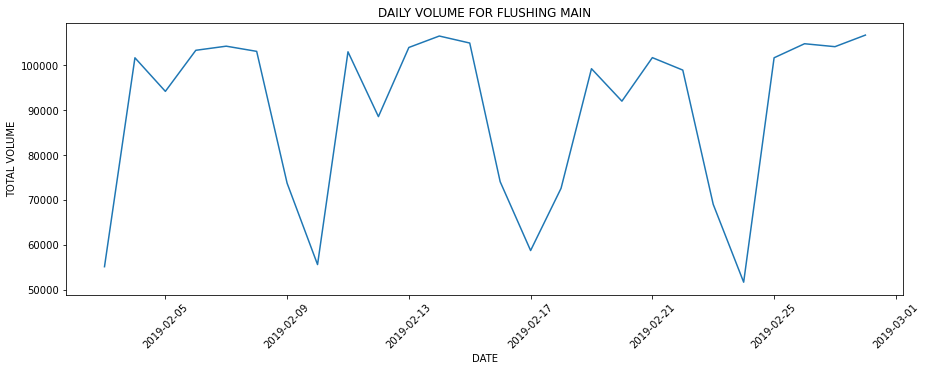

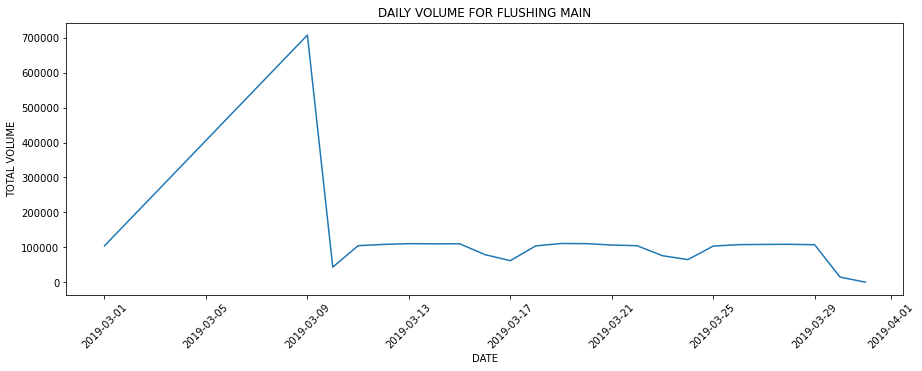

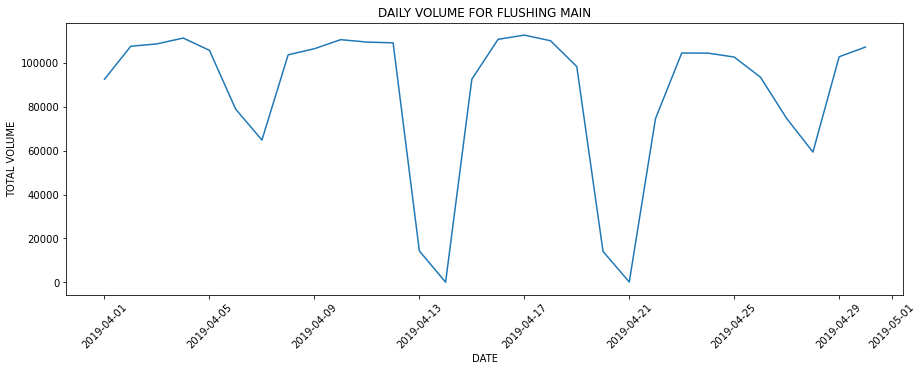

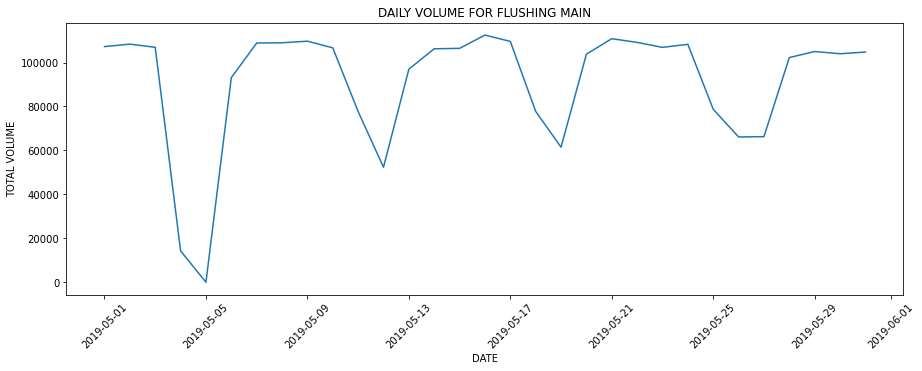

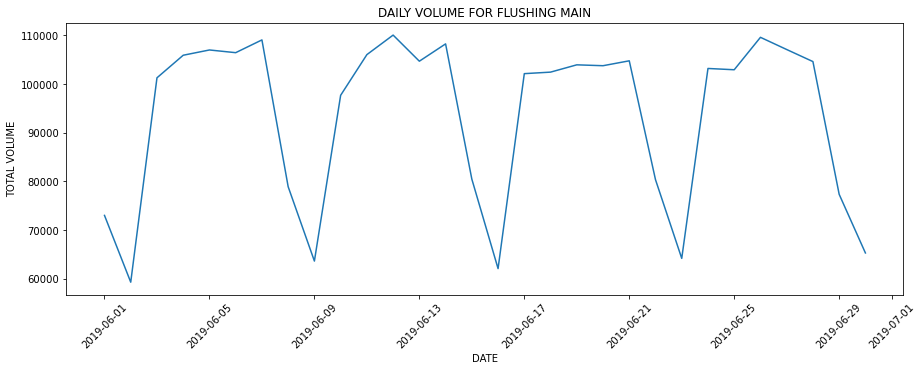

In [257]:
for month, group in flushing_main.groupby(flushing_main.DATE.dt.month):
    if month != 7:
        plt.figure(figsize=(15,5))
        plt.plot('DATE','NET_BUSY',data=group)
        plt.title('DAILY VOLUME FOR FLUSHING MAIN')
        plt.ylabel('TOTAL VOLUME')
        plt.xlabel('DATE')
        plt.xticks(rotation=45)
        plt.title('DAILY VOLUME FOR FLUSHING MAIN')
    #print ('month:',month,'\ngroup:',group)
    # plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])

#fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(10,8));

In [252]:
fig = sns.b(data = stdf_7_daily_corona, 
                  x='DATE', 
                  y ='NET_BUSY')
axes.set_title('VOLUME BY DATE FOR STATION "103 ST CORONA" MTA 7 LINE')
axes.set_ylabel('TOTAL VOLUME')
x_dates = stdf_7_daily_corona['DATE'].dt.strftime('%Y-%m-%d').sort_values()
axes.set_xticklabels(labels=x_dates, rotation=45, ha='right');
plt.savefig('volume_by_date_103_st.png',bbox_inches='tight')

AttributeError: module 'seaborn' has no attribute 'b'